# Algebraic and AI-Assisted Anomaly Detection for Robotic Sensor Data

## Residual and Covariance Methods

- Load normalized datasets
- Apply **Residual-based Anomaly Detection**
- Apply **Covariance-based Anomaly Detection** (Mahalanobis dist)
- Visualize results
- Save results

[INFO] Normalized datasets found:
 - lp1_norm.csv
 - lp2_norm.csv
 - lp3_norm.csv
 - lp4_norm.csv
 - lp5_norm.csv
[INFO] Datasets loaded

lp1: 1320 samples x 6 features
   column_a  column_b  column_c  column_d  column_e  column_f
0  0.026723 -0.216322  0.551551  0.244733   0.03463 -0.047415

lp2: 705 samples x 6 features
   column_a  column_b  column_c  column_d  column_e  column_f
0 -0.061789  0.053368 -0.001656  0.205201  0.120959  0.581038

lp3: 705 samples x 6 features
   column_a  column_b  column_c  column_d  column_e  column_f
0 -0.061789  0.053368 -0.001656  0.205201  0.120959  0.581038

lp4: 1755 samples x 6 features
   column_a  column_b  column_c  column_d  column_e  column_f
0 -0.033193   0.19133  0.308838 -0.004249 -0.044189  0.045708

lp5: 2460 samples x 6 features
   column_a  column_b  column_c  column_d  column_e  column_f
0 -0.034125  0.118464  0.340148 -0.018392  0.001086  0.167733

--> Residual-based detection on lp1 (1320x6)


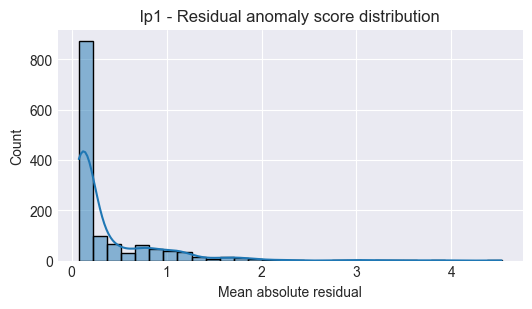


--> Residual-based detection on lp2 (705x6)


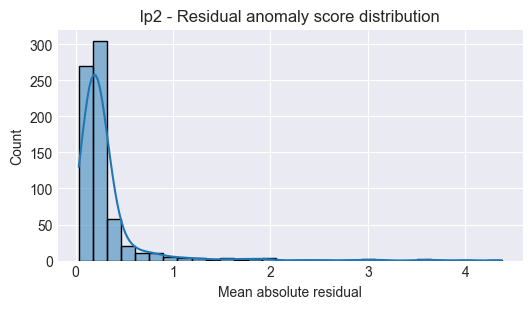


--> Residual-based detection on lp3 (705x6)


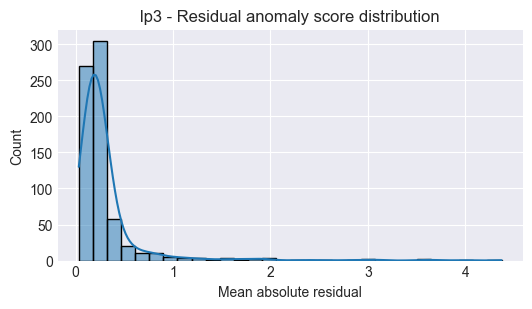


--> Residual-based detection on lp4 (1755x6)


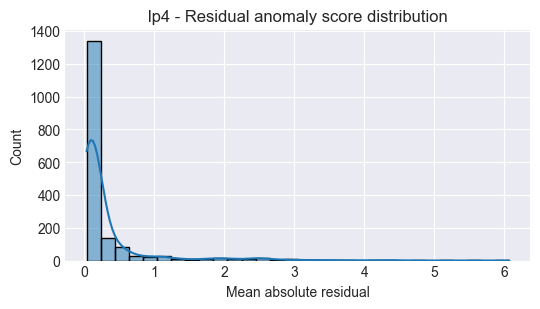


--> Residual-based detection on lp5 (2460x6)


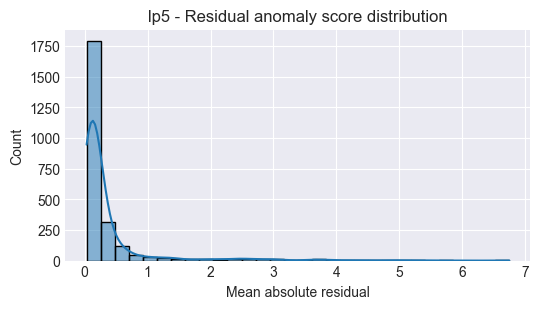


--> lp1: Covariance-based anomalies above threshold: 10.30%


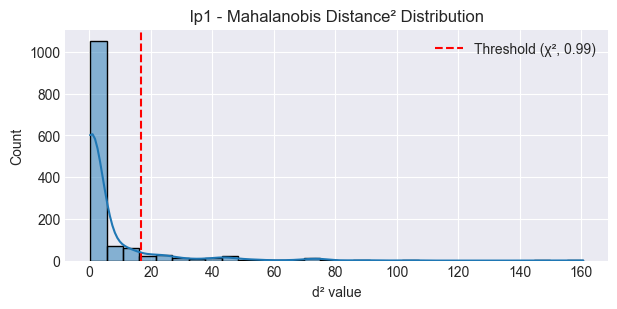


--> lp2: Covariance-based anomalies above threshold: 4.26%


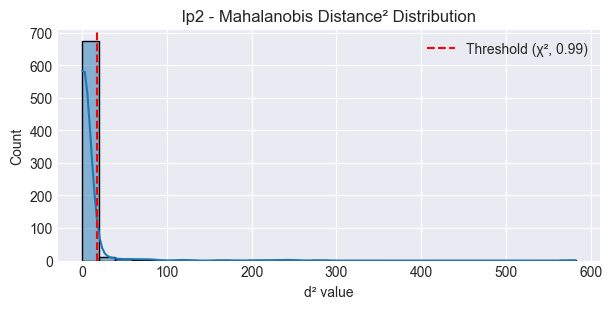


--> lp3: Covariance-based anomalies above threshold: 4.26%


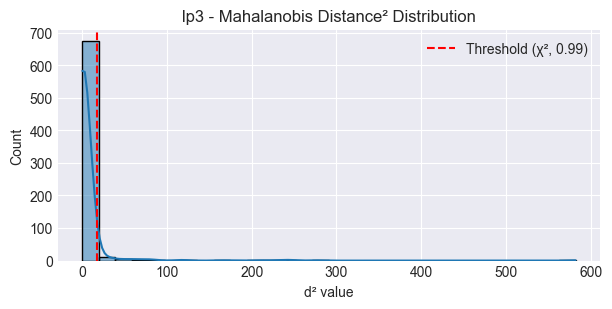


--> lp4: Covariance-based anomalies above threshold: 7.07%


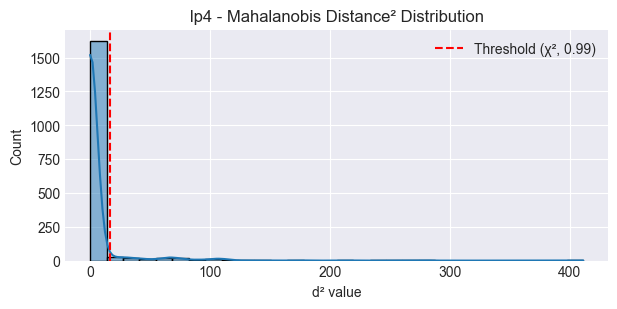


--> lp5: Covariance-based anomalies above threshold: 5.81%


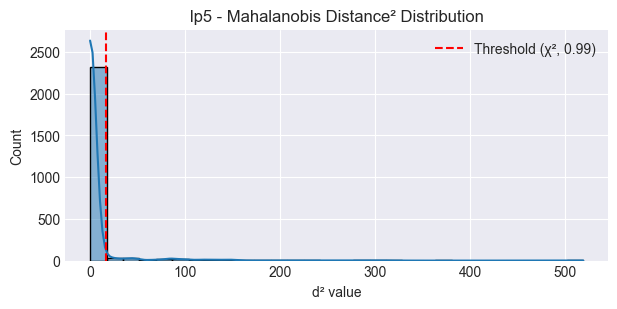

,Dataset,Residual_mean,Residual_std,Covariance_mean,Covariance_std
0,lp1,0.371421,0.506592,6.0,15.244706
1,lp2,0.306733,0.424437,6.0,31.921653
2,lp3,0.306733,0.424437,6.0,31.921653
3,lp4,0.325416,0.649777,6.0,25.274083
4,lp5,0.340503,0.660377,6.0,27.898105


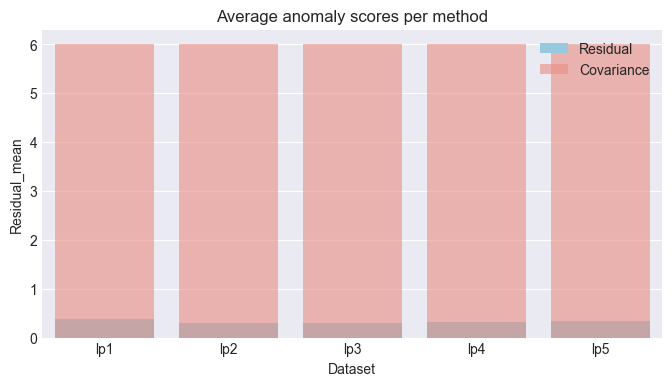


[INFO] Cross-sensor correlation (Residual-based)


,lp1,lp2,lp3,lp4,lp5
lp1,1.000,0.340,0.340,0.186,0.340
lp2,0.340,1.000,1.000,0.143,0.859
lp3,0.340,1.000,1.000,0.143,0.859
lp4,0.186,0.143,0.143,1.000,0.135
lp5,0.340,0.859,0.859,0.135,1.000



[INFO] Cross-sensor correlation (Covariance-based)


,lp1,lp2,lp3,lp4,lp5
lp1,1.000,0.265,0.265,0.014,0.311
lp2,0.265,1.000,1.000,0.004,0.943
lp3,0.265,1.000,1.000,0.004,0.943
lp4,0.014,0.004,0.004,1.000,0.005
lp5,0.311,0.943,0.943,0.005,1.000


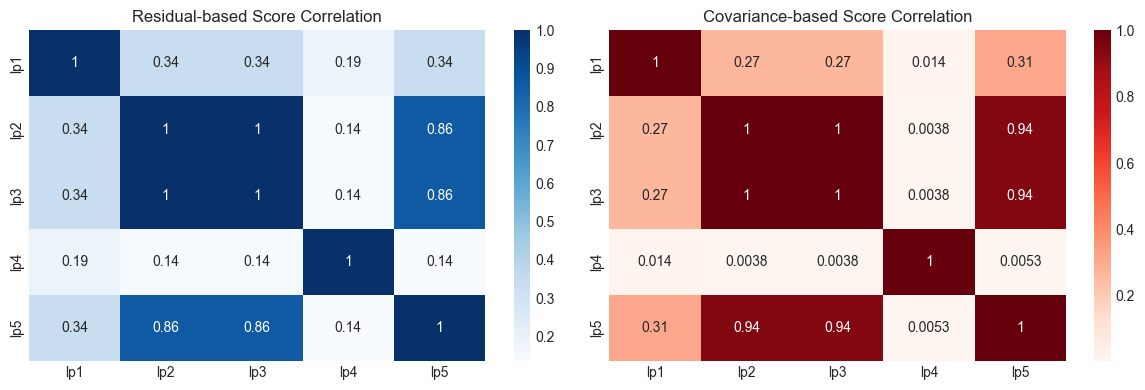

[INFO] Saved: ../results/lp1_residual_cov.csv
[INFO] Saved: ../results/lp2_residual_cov.csv
[INFO] Saved: ../results/lp3_residual_cov.csv
[INFO] Saved: ../results/lp4_residual_cov.csv
[INFO] Saved: ../results/lp5_residual_cov.csv

[INFO] Residual-based and covariance-based anomaly detection completed.


In [36]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import chi2

SEED = 42
np.random.seed(SEED)

plt.style.use("seaborn-v0_8-darkgrid")
pd.set_option("display.max_columns", None)

# --- 2. Paths ---
data_path = Path("../data/normalized")
files = sorted(data_path.glob("*.csv"))

print("[INFO] Normalized datasets found:")
for f in files:
    print(f" - {f.name}")

# --- 3. Load datasets ---
datasets = {f.stem.replace("_norm", ""): pd.read_csv(f) for f in files}
print(f"[INFO] Datasets loaded")

# --- 4. Quick overview ---
for name, df in datasets.items():
    print(f"\n{name}: {df.shape[0]} samples x {df.shape[1]} features")
    print(f"{df.head(1)}")



"""Part 1 -> RESIDUAL-BASED ANOMALY DETECTION"""

residual_scores = {}

for name, df in datasets.items():
    num_df = df.select_dtypes(include=np.number).dropna()
    X = num_df.values
    n, d = X.shape
    print(f"\n--> Residual-based detection on {name} ({n}x{d})")

    residual_matrix = np.zeros_like(X)

    for i in range(d):
        X_i = np.delete(X, i, axis=1)
        y_i = X[:, i]
        model = LinearRegression()
        model.fit(X_i, y_i)
        y_pred = model.predict(X_i)
        residual_matrix[:, i] = y_i - y_pred
    
    residual_score = np.mean(np.abs(residual_matrix), axis=1)
    residual_scores[name] = residual_score

    # Plot distribution
    plt.figure(figsize=(6,3))
    sns.histplot(residual_score, bins=30, kde=True)
    plt.title(f"{name} - Residual anomaly score distribution")
    plt.xlabel("Mean absolute residual")
    plt.ylabel("Count")
    plt.show()


"""Part 2 -> Covariance-based Anomaly Detection"""

covariance_scores = {}

for name, df in datasets.items():
    num_df = df.select_dtypes(include=np.number).dropna()
    X = num_df.values
    n, d = X.shape

    emp_cov = EmpiricalCovariance().fit(X)
    mahalanobis_sq = emp_cov.mahalanobis(X)
    covariance_scores[name] = mahalanobis_sq

    # Chi-square thresh
    thresh = chi2.ppf(0.99, df=d)
    anomaly_mask = mahalanobis_sq > thresh
    anomaly_ratio = anomaly_mask.mean()

    print(f"\n--> {name}: Covariance-based anomalies above threshold: {anomaly_ratio:.2%}")

    # Plot
    plt.figure(figsize=(7,3))
    sns.histplot(mahalanobis_sq, bins=30, kde=True)
    plt.axvline(thresh, color='r', linestyle='--', label=f"Threshold (χ², 0.99)")
    plt.title(f"{name} - Mahalanobis Distance² Distribution")
    plt.xlabel("d² value")
    plt.legend()
    plt.show()


"""Part 3.1 -> Compare and Visualize"""

results_summary = []

for name in datasets.keys():
    residual_mean = np.mean(residual_scores[name])
    residual_std = np.std(residual_scores[name])
    cov_mean = np.mean(covariance_scores[name])
    cov_std = np.std(covariance_scores[name])
    results_summary.append({
        "Dataset": name,
        "Residual_mean": residual_mean,
        "Residual_std": residual_std,
        "Covariance_mean": cov_mean,
        "Covariance_std": cov_std,
    })

results_df = pd.DataFrame(results_summary)
display(results_df)

plt.figure(figsize=(8,4))
sns.barplot(x="Dataset", y="Residual_mean", data=results_df, color="skyblue", label="Residual")
sns.barplot(x="Dataset", y="Covariance_mean", data=results_df, color="salmon", alpha=0.6, label="Covariance")
plt.title("Average anomaly scores per method")
plt.legend()
plt.show()

"""Part 3.2 -> Cross-Sensor Correlation"""

# Align lengths by truncating to min length
min_len = min(len(v) for v in residual_scores.values())

residual_df = pd.DataFrame({name: v[:min_len] for name, v in residual_scores.items()})
covariance_df = pd.DataFrame({name: v[:min_len] for name, v in covariance_scores.items()})

# Correlation matrices
res_corr = residual_df.corr()
cov_corr = covariance_df.corr()

print("\n[INFO] Cross-sensor correlation (Residual-based)")
display(res_corr.round(3))
print("\n[INFO] Cross-sensor correlation (Covariance-based)")
display(cov_corr.round(3))

# Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(res_corr, annot=True, cmap="Blues", ax=axes[0])
axes[0].set_title("Residual-based Score Correlation")
sns.heatmap(cov_corr, annot=True, cmap="Reds", ax=axes[1])
axes[1].set_title("Covariance-based Score Correlation")
plt.tight_layout()
plt.show()



"""Part 4 -> Save"""

output_path = Path("../results")
output_path.mkdir(exist_ok=True)

for name in datasets.keys():
    df_out = pd.DataFrame({
        "residual_score": residual_scores[name],
        "mahalanobis_d2": covariance_scores[name]
    })
    df_out.to_csv(output_path / f"{name}_residual_cov.csv", index=False)
    print(f"[INFO] Saved: {output_path}/{name}_residual_cov.csv")

print("\n[INFO] Residual-based and covariance-based anomaly detection completed.")

- Residual-based Score Correlation -> lp3,lp4,lp5 strongly correlated
- Covariance-based Score Correlation -> lp3,lp4,lp5 strongly correlated

Correlated sensors mean they share similar anomaly patterns, so can have common mechanical issues. In any case, in anomaly case they behave similarly